Watershed

C:\Users\julie\AppData\Local\Temp\ipykernel_13880\3276433509.py:16: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = peak_local_max(distance_map, indices=False, min_distance=70, labels=thresh)


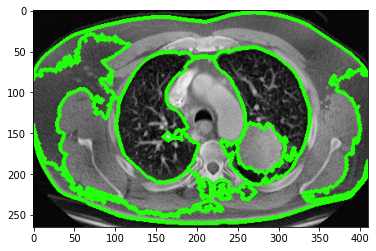

In [111]:
import cv2
import numpy as np
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import matplotlib.pyplot as plt

# Load in image, convert to gray scale, and Otsu's threshold
image = cv2.imread('Cancer_enh.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Compute Euclidean distance from every binary pixel
# to the nearest zero pixel then find peaks
distance_map = ndimage.distance_transform_edt(thresh)
local_max = peak_local_max(distance_map, indices=False, min_distance=70, labels=thresh)

# Perform connected component analysis then apply Watershed
markers = ndimage.label(local_max, structure=np.ones((3, 3)))[0]
labels = watershed(-distance_map, markers, mask=thresh)

# Iterate through unique labels
total_area = 0
for label in np.unique(labels):
    if label == 0:
        continue

    # Create a mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255

    # Find contours and determine contour area
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    c = max(cnts, key=cv2.contourArea)
    area = cv2.contourArea(c)
    total_area += area
    cv2.drawContours(image, [c], -1, (36,255,12), 4)

plt.imshow(image)
plt.show()

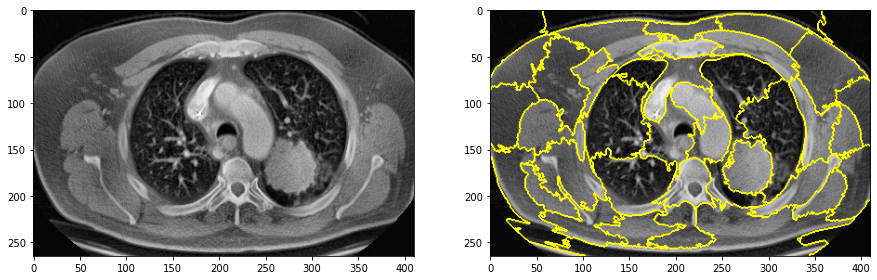

In [36]:
# Importing required boundaries
from skimage.segmentation import slic, mark_boundaries
import cv2
import matplotlib.pyplot as plt
 
# Setting the plot figure as 15, 15
plt.figure(figsize=(15, 15))
 
# Sample Image of scikit-image package
img=cv2.imread("Cancer_enh.png",0)/255
 
# Applying SLIC segmentation
# for the edges to be drawn over
img_segments = slic(img, n_segments=50,compactness=0.1)
 
plt.subplot(1, 2, 1)
 
# Plotting the original image
plt.imshow(img, cmap='gray')
 
# Detecting boundaries for labels
plt.subplot(1, 2, 2)
 
# Plotting the output of marked_boundaries
# function i.e. the image with segmented boundaries
plt.imshow(mark_boundaries(img, img_segments))

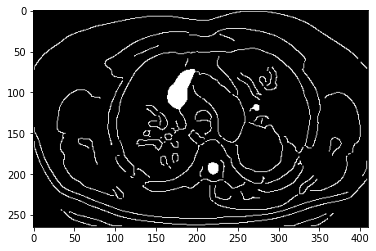

In [37]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2 ,os
from math import ceil
import pickle
import time
from skimage import io, feature
from skimage.color import rgb2gray
from scipy import ndimage as ndi
from skimage import morphology
from skimage.feature import canny
from skimage.restoration import estimate_sigma

foreground_value = 0
foreground_pixels=[]
segmented_images=[]


def read_image_files(dir):
    images = []
    filenames = os.listdir(dir)
    for filename in filenames:
        images.append(cv2.imread(dir + filename, 0))
    return images



def edge_based_segmentation(image):
    noise = estimate_sigma(image)
    edges = canny(image, sigma=3)
    filled = ndi.binary_fill_holes(edges)
    filled_cleaned = morphology.remove_small_objects(filled, 2)
    segmented_images.append(filled_cleaned)
    pixels=np.argwhere(filled_cleaned == foreground_value)
    foreground_pixels.append(pixels)
    return

img=cv2.imread('Cancer_enh.png',0)/255
edge_based_segmentation(img)

np.save('EdgeBasedSegmentation',foreground_pixels)
plt.imshow(segmented_images[0],'gray')

Text(0.5, 1.0, 'Region growing')

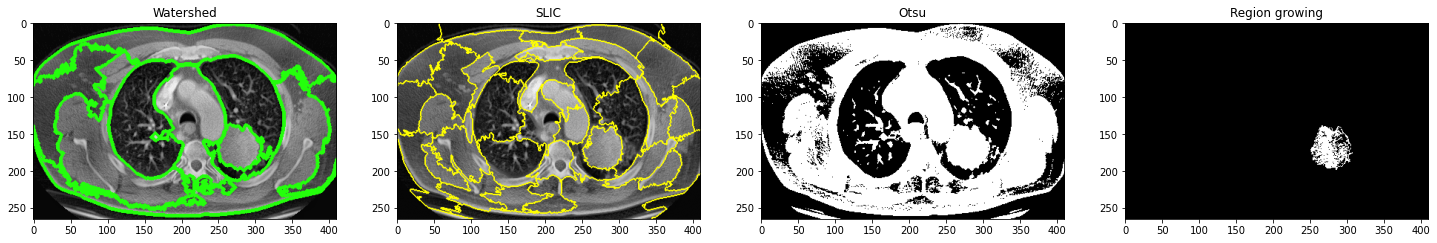

In [38]:
import matplotlib.pyplot as plt
import cv2
from skimage.segmentation import flood, flood_fill

fig = plt.figure()
fig.set_figheight(11)
fig.set_figwidth(25)

fig.add_subplot(1,4,1)
plt.imshow(image, cmap='gray')
plt.title('Watershed')

fig.add_subplot(1,4,2)
plt.imshow(mark_boundaries(img, img_segments))
plt.title('SLIC')

img=cv2.imread('Cancer_enh.png',0)
ret, thresh = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  
fig.add_subplot(1,4,3)
plt.imshow(thresh, cmap='gray')
plt.title('Otsu')

light_coat = flood(img, seed_point=(175, 275), tolerance=20)
fig.add_subplot(1,4,4)
plt.imshow(light_coat, cmap='gray')
plt.title('Region growing')


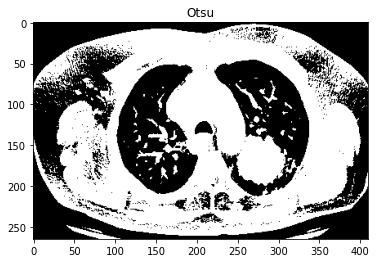

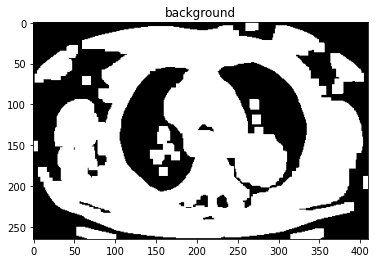

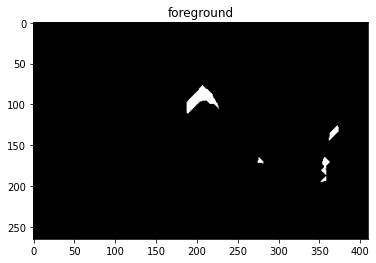

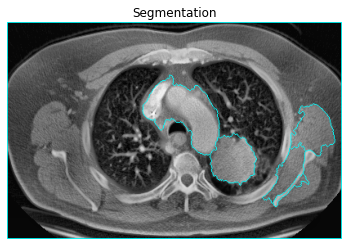

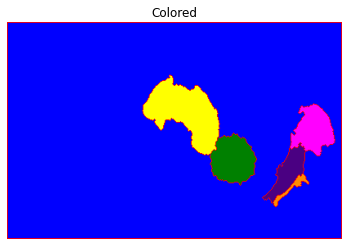

In [116]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io

### Obtain Binary Image

img = cv2.imread("Cancer_enh.png")
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Threshold image to binary using OTSU. Enforce inversion to set objects as 1 and background as 0.
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 

plt.imshow(thresh,cmap='gray')
plt.title('Otsu')

# Morphological operations to remove noise - opening
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)


### Watershed Segmentation

# sure background
sure_bg = cv2.dilate(opening, kernel,iterations=3)
plt.figure()
plt.imshow(sure_bg,cmap='gray')
plt.title('background')

# sure foreground
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L1,3)
ret2, sure_fg = cv2.threshold(dist_transform,0.75*dist_transform.max(),255,0)

# Unknown region
sure_fg = np.uint8(sure_fg)  #Convert to uint8 from float
unknown = cv2.subtract(sure_bg,sure_fg)
plt.figure()
plt.imshow(sure_fg,cmap='gray')
plt.title('foreground')

# markers
ret3, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0

# watershed 
markers = cv2.watershed(img,markers)

# segment nuclei
img[markers == -1] = [0,255,255]  
img2 = color.label2rgb(markers, bg_label=0)

# show results
plt.figure()
plt.imshow(img)
plt.axis('off')
plt.title('Segmentation')
plt.figure()
plt.imshow(img2)
plt.axis('off')
plt.title('Colored')
plt.show()